In [99]:
import torch
import torch.nn.functional as F
import PIL
from PIL import Image
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel

In [100]:
'''
Load a Pretrained model from resNet
'''
model = models.resnet18(pretrained=True)
model = model.eval()

In [101]:
'''
Download the json file describing the data that will be classified and visualized
'''
#/Users/michaelskaro/Desktop/DataMining/GVF_computer_vision




'\nDownload the json file describing the data that will be classified and visualized\n'

In [102]:
labels_path = "annot.json"
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

In [103]:
import cv2
 
src = cv2.imread('NORMAL2-IM-0033-0001.jpeg', cv2.IMREAD_UNCHANGED)


# dsize
dsize = (1280, 853)

# resize image
output = cv2.resize(src, dsize, interpolation = cv2.INTER_AREA)

cv2.imwrite('NORMAL2-IM-0033-0001_rs.jpeg',output) 

True

In [104]:
idx_to_labels

{'filepath': {'0': '/home/jovyan/work/chest_xray/train/PNEUMONIA/person59_bacteria_280.jpeg',
  '1': '/home/jovyan/work/chest_xray/train/PNEUMONIA/person1651_bacteria_4381.jpeg',
  '2': '/home/jovyan/work/chest_xray/train/PNEUMONIA/person1173_virus_1978.jpeg',
  '3': '/home/jovyan/work/chest_xray/train/PNEUMONIA/person395_bacteria_1794.jpeg',
  '4': '/home/jovyan/work/chest_xray/train/PNEUMONIA/person1604_virus_2782.jpeg',
  '5': '/home/jovyan/work/chest_xray/train/PNEUMONIA/person458_virus_945.jpeg',
  '6': '/home/jovyan/work/chest_xray/train/PNEUMONIA/person1700_bacteria_4502.jpeg',
  '7': '/home/jovyan/work/chest_xray/train/PNEUMONIA/person503_bacteria_2126.jpeg',
  '8': '/home/jovyan/work/chest_xray/train/PNEUMONIA/person647_virus_1229.jpeg',
  '9': '/home/jovyan/work/chest_xray/train/PNEUMONIA/person104_virus_191.jpeg',
  '10': '/home/jovyan/work/chest_xray/train/PNEUMONIA/person156_virus_308.jpeg',
  '11': '/home/jovyan/work/chest_xray/train/PNEUMONIA/person1248_virus_2117.jpeg',

In [105]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )
from array import array
img = cv.imread('NORMAL2-IM-0112-0001.jpeg',0)
img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
as_array = np.array(img) 
pil_image=Image.fromarray(as_array)
transformed_img = transform(pil_image)
input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [112]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
#predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
#print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)



## Option 1: Gradient attribution
Gradient attributions using Integrated Gradients and visualize them on the image. Integrated gradients computes the integral of the gradients of the output of the model for the predicted class pred_label_idx with respect to the input image pixels along the path from the black image to our input image.

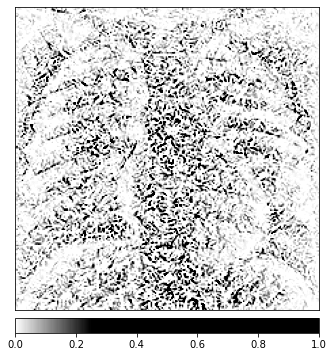

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd319b8c790>)

In [121]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

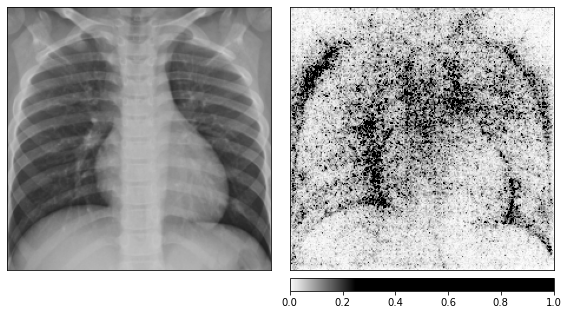

(<Figure size 576x432 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd18bd61e50>,
       dtype=object))

In [122]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

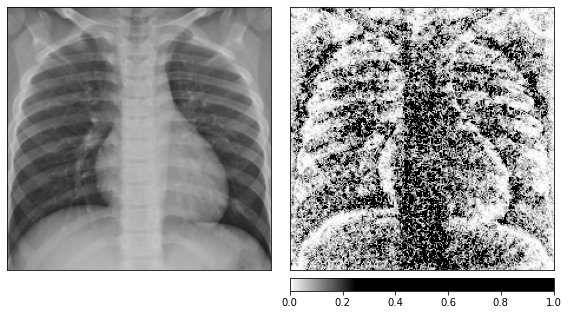

(<Figure size 576x432 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd30f062ca0>,
       dtype=object))

In [123]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [124]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

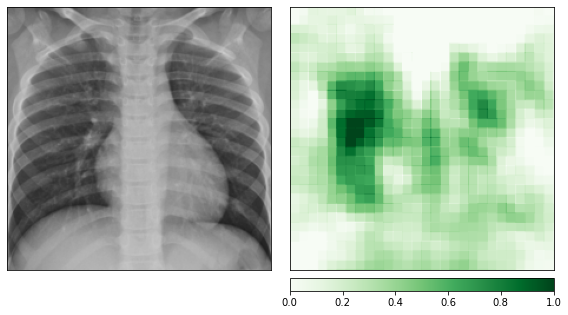

(<Figure size 576x432 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd35fb904c0>,
       dtype=object))

In [125]:
viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

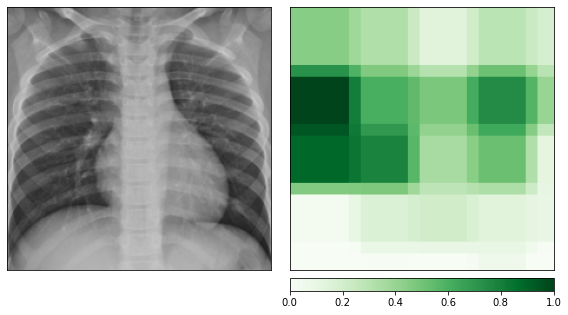

(<Figure size 576x432 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfec503370>,
       dtype=object))

In [126]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

In [ ]:
#Code implemented by cloning github repo from the github source:
#https://github.com/t-suzuki/gradient_vector_flow_test/blob/master/gvf.py
###Importnat updates to the code:
###The skimage gussian filters were updated and the sk image import should be replaced with open cv

In [32]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from array import array

#img = cv.imread('IM-0033-0001-0001.jpeg',0)
img = cv.imread('NORMAL2-IM-0112-0001.jpeg',0)

Text(0.5, 1.0, 'Original image')

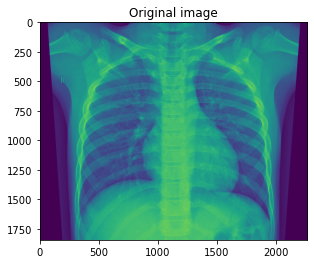

In [35]:
as_array = np.array(img) 
# compute gradient of image
fx, fy = np.gradient(as_array)

plt.imshow(img)
plt.title('Original image')

In [36]:
import sys
import skimage.color
import skimage.data
import skimage.transform
try:
    import skimage.filter as skimage_filter
except:
    import skimage.filters as skimage_filter
import numpy as np
import matplotlib.pyplot as plt

def gradient_field(im):
    im = skimage.filters.gaussian(im, 1.0)
    gradx = np.hstack([im[:, 1:], im[:, -2:-1]]) - np.hstack([im[:, 0:1], im[:, :-1]]) 
    grady = np.vstack([im[1:, :], im[-2:-1, :]]) - np.vstack([im[0:1, :], im[:-1, :]]) 
    return gradx, grady

def edge_map(img, sigma):
    blur = skimage.filters.gaussian(img, sigma)
    return skimage_filter.sobel(blur)

def gradient_vector_flow(fx, fy, mu, dx=1.0, dy=1.0, verbose=True):
    u'''calc gradient vector flow of input gradient field fx, fy'''
    # calc some coefficients.
    b = fx**2.0 + fy**2.0
    c1, c2 = b*fx, b*fy
    # calc dt from scaling parameter r.
    r = 0.25 # (17) r < 1/4 required for convergence.
    dt = dx*dy/(r*mu)
    # max iteration
    N = int(max(1, np.sqrt(img.shape[0]*img.shape[1])))
    # initialize u(x, y), v(x, y) by the input.
    curr_u = fx
    curr_v = fy
    def laplacian(m):
        return np.hstack([m[:, 0:1], m[:, :-1]]) + np.hstack([m[:, 1:], m[:, -2:-1]]) \
                + np.vstack([m[0:1, :], m[:-1, :]]) + np.vstack([m[1:, :], m[-2:-1, :]]) \
                - 4*m
    for i in range(N):
        next_u = (1.0 - b*dt)*curr_u + r*laplacian(curr_u) + c1*dt
        next_v = (1.0 - b*dt)*curr_v + r*laplacian(curr_v) + c2*dt
        curr_u, curr_v = next_u, next_v
        if verbose:
            sys.stdout.write('.')
            sys.stdout.flush()
    if verbose:
        sys.stdout.write('\n')
    return curr_u, curr_v

In [37]:
def add_border(img, width):
    h, w = img.shape
    val = img[:, 0].mean() + img[:, -1].mean() + img[0, :].mean() + img[-1, :].mean()
    res = np.zeros((h + width*2, w + width*2), dtype=img.dtype) + val
    res[width:h+width, width:w+width] = img
    res[:width, :] = res[width, :][np.newaxis, :]
    res[:, :width] = res[:, width][:, np.newaxis]
    res[h+width:, :] = res[h+width-1, :][np.newaxis, :]
    res[:, w+width:] = res[:, w+width-1][:, np.newaxis]
    return res

In [38]:
img = img.astype(np.float32) / 255.0
img = add_border(img, 32)
edge = edge_map(img, sigma=2)
fx, fy = gradient_field(edge)
gx, gy = gradient_vector_flow(fx, fy, mu=1.0)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

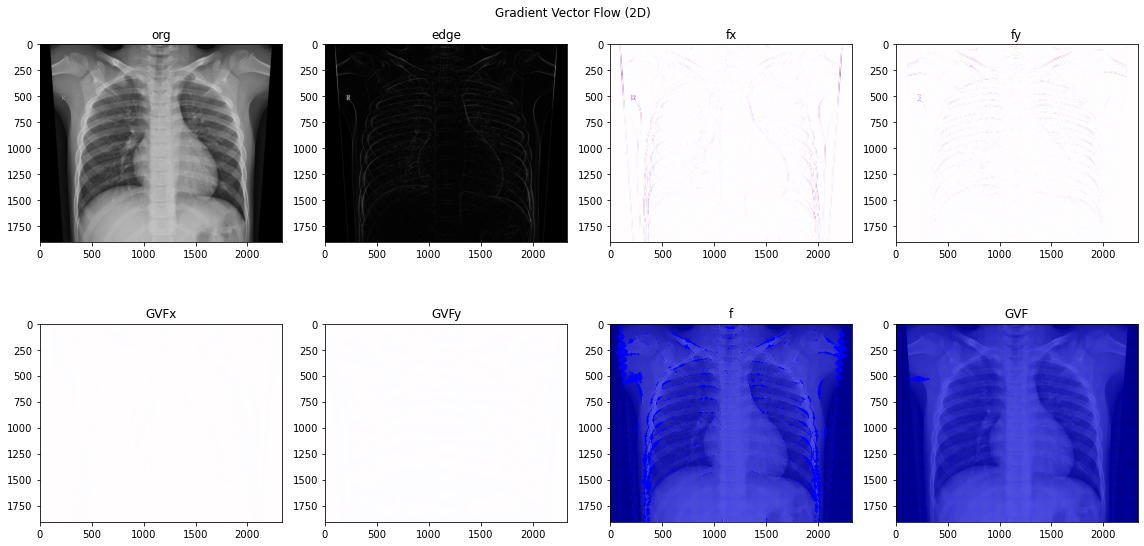

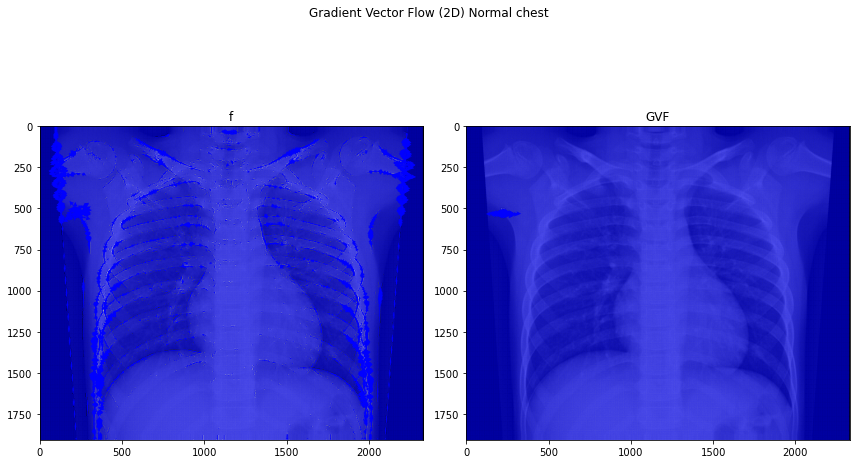

In [39]:
# plot the results
H, W = img.shape
Y, X = np.meshgrid(range(0, H, 5), range(0, W, 5))
def plot_vector_field(ax, vx, vy):
    scale = np.sqrt(np.max(vx**2+vy**2))*20.0
    ax.imshow(img, cmap='gray')
    # vy shold be inversed (top=+Y -> top=-Y)
    ax.quiver(X, Y, vx[Y, X], -vy[Y, X], scale=scale, color='blue', headwidth=5)
def vmin(values): return -max(values.max(), -values.min())
def vmax(values): return max(values.max(), -values.min())
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Gradient Vector Flow (2D)')
ax = axs[0][0]; ax.imshow(img, cmap='gray'); ax.set_title('org')
ax = axs[0][1]; ax.imshow(edge[:, :], cmap='gray'); ax.set_title('edge')
ax = axs[0][2]; ax.imshow(fx, vmin=vmin(fx), vmax=vmax(fx), cmap='seismic'); ax.set_title('fx')
ax = axs[0][3]; ax.imshow(fy, vmin=vmin(fx), vmax=vmax(fx), cmap='seismic'); ax.set_title('fy')
ax = axs[1][0]; ax.imshow(gx, vmin=vmin(gx), vmax=vmax(gx), cmap='seismic'); ax.set_title('GVFx')
ax = axs[1][1]; ax.imshow(gy, vmin=vmin(gy), vmax=vmax(gy), cmap='seismic'); ax.set_title('GVFy')
ax = axs[1][2]; plot_vector_field(ax, fx, fy); ax.set_title('f')
ax = axs[1][3]; plot_vector_field(ax, gx, gy); ax.set_title('GVF')
fig.tight_layout()
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
fig.suptitle('Gradient Vector Flow (2D) Normal chest')
ax = axs[0]; plot_vector_field(ax, fx, fy); ax.set_title('f')
ax = axs[1]; plot_vector_field(ax, gx, gy); ax.set_title('GVF')
fig.tight_layout()
plt.show()

In [21]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from array import array
img = cv.imread('person109_bacteria_523.jpeg',0)

Text(0.5, 1.0, 'Original image')

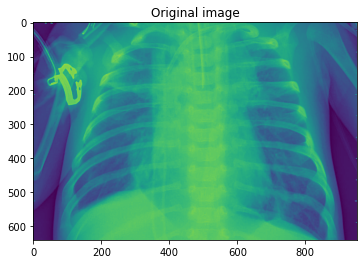

In [22]:
as_array = np.array(img) 
# compute gradient of image
fx, fy = np.gradient(as_array)

plt.imshow(img)
plt.title('Original image')

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

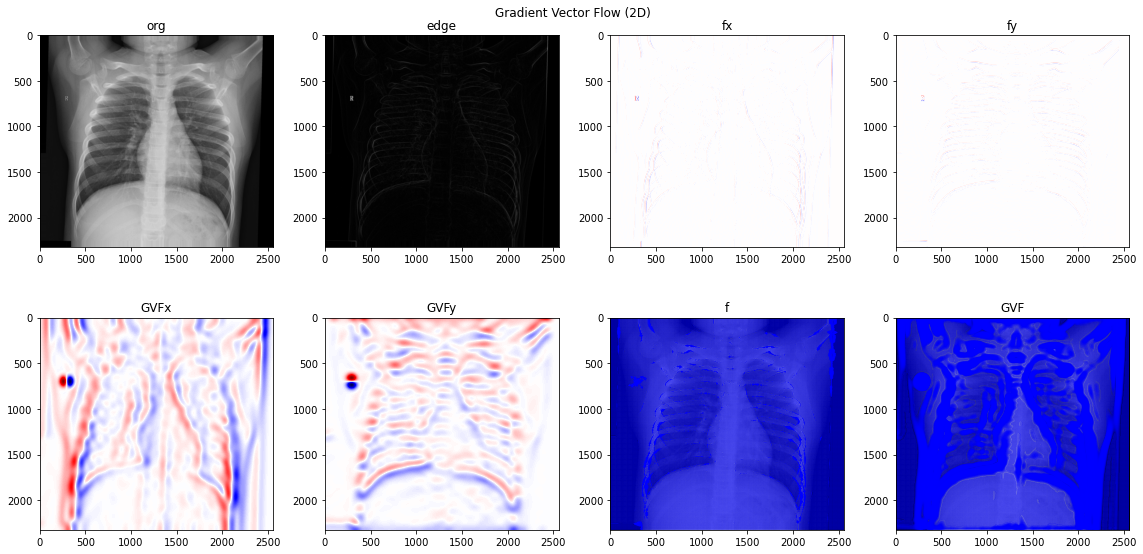

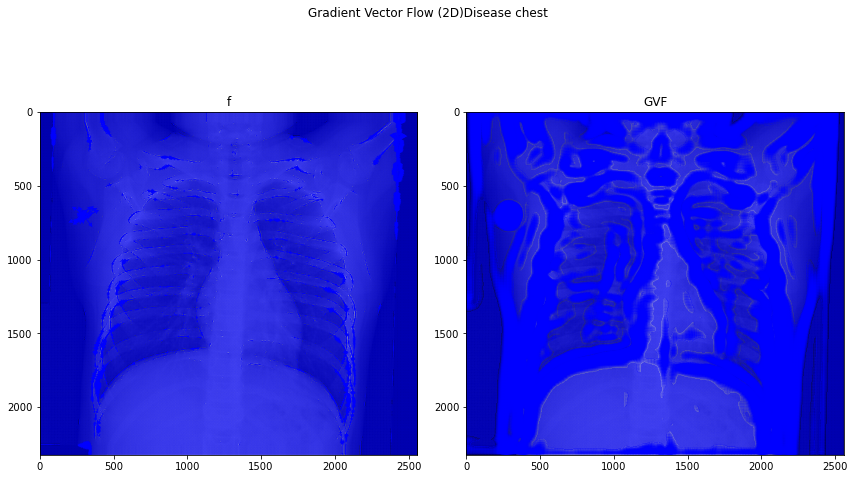

In [31]:
img = img.astype(np.float32) / 255.0
img = add_border(img, 32)
edge = edge_map(img, sigma=2)
fx, fy = gradient_field(edge)
gx, gy = gradient_vector_flow(fx, fy, mu=1.0)

# plot the results
H, W = img.shape
Y, X = np.meshgrid(range(0, H, 5), range(0, W, 5))

fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Gradient Vector Flow (2D)')
ax = axs[0][0]; ax.imshow(img, cmap='gray'); ax.set_title('org')
ax = axs[0][1]; ax.imshow(edge[:, :], cmap='gray'); ax.set_title('edge')
ax = axs[0][2]; ax.imshow(fx, vmin=vmin(fx), vmax=vmax(fx), cmap='seismic'); ax.set_title('fx')
ax = axs[0][3]; ax.imshow(fy, vmin=vmin(fx), vmax=vmax(fx), cmap='seismic'); ax.set_title('fy')
ax = axs[1][0]; ax.imshow(gx, vmin=vmin(gx), vmax=vmax(gx), cmap='seismic'); ax.set_title('GVFx')
ax = axs[1][1]; ax.imshow(gy, vmin=vmin(gy), vmax=vmax(gy), cmap='seismic'); ax.set_title('GVFy')
ax = axs[1][2]; plot_vector_field(ax, fx, fy); ax.set_title('f')
ax = axs[1][3]; plot_vector_field(ax, gx, gy); ax.set_title('GVF')
fig.tight_layout()
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
fig.suptitle('Gradient Vector Flow (2D)Disease chest')
ax = axs[0]; plot_vector_field(ax, fx, fy); ax.set_title('f')
ax = axs[1]; plot_vector_field(ax, gx, gy); ax.set_title('GVF')
fig.tight_layout()
plt.show()